In [ ]:
 # installing required libraries
!pip install transformers
!pip install sentencepiece
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.5 MB/s 
     |████████████████████████████████| 7.6 MB 73.2 MB/s 
     |████████████████████████████████| 182 kB 97.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 4.4 MB/s 
     |████████████████████████████████| 110 kB 91.7 MB/s 


In [ ]:
# downloading glove
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2022-12-04 06:49:40--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2022-12-04 06:49:40--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2022-12-04 06:49:40--  https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm
from tqdm import tqdm, trange
from ast import literal_eval
import json

import tensorflow as tf
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.nn import softmax
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, Masking
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import Model
from keras.optimizers import Adam, Adamax
from keras.utils import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy, BinaryAccuracy
from keras import backend as K
from transformers import RobertaTokenizer, RobertaForSequenceClassification, BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import TFBertForSequenceClassification, TFRobertaForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

import nltk
import gensim
from nltk.data import find
from nltk.tokenize import LineTokenizer, sent_tokenize, TweetTokenizer
nltk.download('punkt')
nltk.download('word2vec_sample')
nltk.download('stopwords')

import re
import contractions
import zipfile
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Package word2vec_sample is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# mount google drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


# Data Collection

In [2]:
# load data from kaggle
train = pd.read_csv("/content/drive/My Drive/255/train.csv")
test = pd.read_csv("/content/drive/My Drive/255/test.csv")
sample = pd.read_csv("/content/drive/My Drive/255/sample_submission.csv")

In [3]:
# training set shape and head
print(train.shape)
train.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# check missing values and data type
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [6]:
# testing text shape and head
print(test.shape)
test.head()

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# check missing values and data type
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [8]:
# sample submission shape and head
print(sample.shape)
sample.head()

(3263, 2)


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


# Data Cleaning

In [9]:
# check if there is mislabeled text
df_mislabeled = train.groupby(['text']).nunique().sort_values(by = 'target', ascending = False)
df_mislabeled = df_mislabeled[df_mislabeled.target > 1]['target'].index.tolist()
df_mislabeled

['like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 'To fight bioterrorism sir.',
 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'He came to a land which was engulfed in tribal war and turned it into a land 

In [10]:
# print the mislabeled text and target
for tweet in df_mislabeled:
    print(train[train.text == tweet][['text', 'target']])

                                                   text  target
1221  like for the music video I want some real acti...       1
1349  like for the music video I want some real acti...       0
                                                   text  target
4306  Hellfire! We donÛªt even want to think about ...       0
4320  Hellfire! We donÛªt even want to think about ...       1
                                                   text  target
4284  The Prophet (peace be upon him) said 'Save you...       0
4286  The Prophet (peace be upon him) said 'Save you...       0
4292  The Prophet (peace be upon him) said 'Save you...       1
4304  The Prophet (peace be upon him) said 'Save you...       0
4309  The Prophet (peace be upon him) said 'Save you...       0
4318  The Prophet (peace be upon him) said 'Save you...       1
                                                   text  target
6614  In #islam saving a person is equal in reward t...       0
6616  In #islam saving a person is equal

In [11]:
# correct the target
train['new_target'] = train.target
train.loc[train.text == df_mislabeled[0], 'new_target'] = 0
train.loc[train.text == df_mislabeled[1], 'new_target'] = 0
train.loc[train.text == df_mislabeled[2], 'new_target'] = 0
train.loc[train.text == df_mislabeled[3], 'new_target'] = 0
train.loc[train.text == df_mislabeled[4], 'new_target'] = 0
train.loc[train.text == df_mislabeled[5], 'new_target'] = 0
train.loc[train.text == df_mislabeled[6], 'new_target'] = 0
train.loc[train.text == df_mislabeled[7], 'new_target'] = 0
train.loc[train.text == df_mislabeled[8], 'new_target'] = 0
train.loc[train.text == df_mislabeled[9], 'new_target'] = 1
train.loc[train.text == df_mislabeled[10], 'new_target'] = 0
train.loc[train.text == df_mislabeled[11], 'new_target'] = 1
train.loc[train.text == df_mislabeled[12], 'new_target'] = 0
train.loc[train.text == df_mislabeled[13], 'new_target'] = 0
train.loc[train.text == df_mislabeled[14], 'new_target'] = 1
train.loc[train.text == df_mislabeled[15], 'new_target'] = 1
train.loc[train.text == df_mislabeled[16], 'new_target'] = 0
train.loc[train.text == df_mislabeled[17], 'new_target'] = 0

In [12]:
# check if they are all correctly labeled now
for tweet in df_mislabeled:
    print(train[train.text == tweet][['text','new_target']])

                                                   text  new_target
1221  like for the music video I want some real acti...           0
1349  like for the music video I want some real acti...           0
                                                   text  new_target
4306  Hellfire! We donÛªt even want to think about ...           0
4320  Hellfire! We donÛªt even want to think about ...           0
                                                   text  new_target
4284  The Prophet (peace be upon him) said 'Save you...           0
4286  The Prophet (peace be upon him) said 'Save you...           0
4292  The Prophet (peace be upon him) said 'Save you...           0
4304  The Prophet (peace be upon him) said 'Save you...           0
4309  The Prophet (peace be upon him) said 'Save you...           0
4318  The Prophet (peace be upon him) said 'Save you...           0
                                                   text  new_target
6614  In #islam saving a person is equal in rewa

# Data Preprocessing

In [13]:
# This function processes the sentence so that it can be used to produce meaningful embeddings
def processSentence(text):

    # Lowercasing
    text = text.lower()

    # Removing HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Removing urls
    text = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]|\(([^\s()<>]|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''," ",text)
    
    # Removing email addresses
    text = re.sub(r'''\S*@\S*\s?''', " ", text)

    # Removing mentioned users
    text = re.sub(r'@\w+', '', text)

    # Removing numbers
    text = re.sub(r'\w*\d+\w*', '', text)

    # Removing puntuations
    text = re.sub(r'[^\w\s]', '', text)

    # Removing new line characters
    text = text.replace('\\n', '')
    
    # Expanding the contractions
    text = contractions.fix(text)
    
    return text

In [14]:
# This function processes the text so that it can be used to produce meaningful embeddings
def processText(text):
    
    # Using the line tokenizer to split using new line character (\n) and discarding the blank lines
    if text is not None:
        
        lines = LineTokenizer(blanklines = 'discard').tokenize(text)
        sentences = []

        # For each line found above we are doing sentence tokenization
        for line in lines:
            currentSentences = sent_tokenize(line)
            
            # sentences.extend([sentence for sentence in currentSentences ])
            for sentence in currentSentences:
                currentText = str(sentence.encode("ascii", "ignore").decode().strip())
                sentences.extend([currentText])
                text = '. '.join([processSentence(sentence) for sentence in sentences])
    return text

In [15]:
emojis = ["\U0001F600", "\U0001F64F", "\U0001F300", "\U0001F5FF", "\U0001F680", "\U0001F6FF", "\U0001F1E0", "\U0001F1FF", "\U00002702", "\U000027B0", "\U000024C2", "\U0001F251"]
stopWords = nltk.corpus.stopwords.words("english")
token = nltk.tokenize.RegexpTokenizer(r"\w+")
lemmatizer = nltk.stem.WordNetLemmatizer()

In [16]:
# cleaner for bert
def cleaner(DF, labeled=True, stopWrds=True, Lemmatize=True, dropDigits=True, dropSinLet=True, c="text"):
    fake = []
    real = []
    data = []
    col = np.where(DF.columns == c)[0][0]
    
    for i, row in enumerate(DF.iterrows()):

        sentence = row[1][col]
        sentence = sentence.lower().split(" ")
        sentence = [word for word in sentence if word not in emojis]
        sentence = [word for word in sentence if 
                  "http" not in word and 
                  "https" not in word and 
                  "@" not in word]
        sentence=[contractions.fix(word) for word in sentence]
        sentence=" ".join(sentence).lower()
        sentence=token.tokenize(sentence)
        if stopWrds == True:
            sentence =[word for word in sentence if word not in stopWords]
        if Lemmatize == True:
            sentence= [lemmatizer.lemmatize(word) for word in sentence]
        sentence = [word.strip() for word in sentence]
        if dropDigits == True:
            sentence = [word for word in sentence if not re.match(r"\S*\d+\S*", word)]
        sentence = [word for word in sentence if 
                  word != "rt" and 
                  word != "û_" and 
                  word != "amp" and 
                  word != "ûª" and
                  word != "ûªs" and
                  word != "ûò" and
                  word != "åè" and
                  word != "ìñ1"] 
        sentence=[re.sub(r"(.)\1{2,}\B", r"\1\1", word) for word in sentence]
        sentence=[re.sub(r"(.)\1{2,}\b", r"\1\1", word) for word in sentence]
        if dropSinLet == True:
            sentence=[word for word in sentence if len(word) > 1]
        sentence=[word for word in sentence if len(word) < 30]
        
        if labeled == True:
            if row[1][4] == 1:
                fake.extend(sentence)
            else:
                real.extend(sentence)

        data.append(" ".join(sentence))
        
    return data, fake, real

In [17]:
# sample original text 
train['text'][:10]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

In [18]:
# apply preprocessing on train and test
train["text"] = train["text"].apply(processText)
test["text"] = test["text"].apply(processText)

In [19]:
# sample text before preprocessing
train['text'][:10]

0    our deeds are the reason of this earthquake ma...
1               forest fire near la ronge sask. canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
5    rockyfire update  california hwy.  closed in b...
6    flood disaster heavy rain causes flash floodin...
7    i am on top of the hill and i can see a fire i...
8    there is an emergency evacuation happening now...
9    i am afraid that the tornado is coming to our ...
Name: text, dtype: object

In [20]:
# x is text, y is labels
X_train = train["text"]
X_test = test["text"]
y_train = train[["new_target"]].values

# Modeling and Evaluation

In [21]:
# helper function to calculate recall, precision, and f1 score
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Word2Vec+LSTM

In [22]:
# make a copy of train and est
train_copy = train.copy()
test_copy = test.copy()

In [23]:
# tokenizer
tknzr = TweetTokenizer(preserve_case = False, reduce_len = True, strip_handles = True)

In [24]:
# convert a string of words into a list of tokens
def tokenize_tweets(tokenizer, input_text):
    tokens = list(tokenizer.tokenize(input_text))
    tokens = [re.sub('[^A-Za-z0-9]+', '', i) for i in tokens]
    return tokens

In [25]:
# convert to tokens
train_copy['tokens'] = train_copy['text']
train_copy['tokens'] = train_copy['tokens'].apply(lambda x: tokenize_tweets(tknzr, x))
test_copy['tokens'] = test_copy['text'].apply(lambda x: tokenize_tweets(tknzr, x))

In [26]:
# max length
max_tweet_length = max(train_copy['tokens'].apply(lambda x: len(x)).max(), 
                       test_copy['tokens'].apply(lambda x: len(x)).max())
print(max_tweet_length)

37


In [27]:
# pretrained word2vec
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary = False)

In [28]:
# compute the embedding for every word
def vectorize_tokens(data_, vec_model, max_seq, num_features):
    data_in = data_.copy()
    all_vectors = []

    for _, row in data_in.iterrows():
        text_vectors = np.zeros((max_seq, num_features))
        for i, item in enumerate(row['tokens']):
            try:
                text_vectors[i, :] = vec_model[item]
            except:
                continue
        all_vectors.append(text_vectors)
    
    return all_vectors

In [29]:
# convert to vectors
max_tweet_length = 32
features = 300

train_copy['vectors'] = vectorize_tokens(data_ = train_copy, 
                                         vec_model = word2vec_model, 
                                         max_seq = max_tweet_length, 
                                         num_features = features)

test_copy['vectors'] = vectorize_tokens(data_ = test_copy, 
                                        vec_model = word2vec_model, 
                                        max_seq = max_tweet_length, 
                                        num_features = features)

In [30]:
# 3D array of text_count, max_sequence_length, embedding_size
X = np.asarray(train_copy['vectors'].tolist()).astype(np.float32)
y = np.asarray(train_copy['new_target'].tolist()).astype(np.float32)
test_array = np.asarray(test_copy['vectors'].tolist()).astype(np.float32)

In [31]:
# model
lstm_model = Sequential([Input(shape = (max_tweet_length, features)),
                         Masking(),
                         LSTM(units = 32),
                         Dropout(0.1),
                         Dense(units = 1, activation = 'sigmoid')])

# compile
lstm_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', f1_m])

In [32]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 32, 300)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                42624     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 42,657
Trainable params: 42,657
Non-trainable params: 0
_________________________________________________________________


In [33]:
# training
lstm_history = lstm_model.fit(X, y, validation_split = 0.2, epochs = 10)

Epoch 1/10
191/191 [==============================] - 18s 68ms/step - loss: 0.5509 - accuracy: 0.7407 - f1_m: 0.6297 - val_loss: 0.4910 - val_accuracy: 0.7610 - val_f1_m: 0.5971
Epoch 2/10
191/191 [==============================] - 12s 62ms/step - loss: 0.4720 - accuracy: 0.7947 - f1_m: 0.7254 - val_loss: 0.4654 - val_accuracy: 0.7853 - val_f1_m: 0.6446
Epoch 3/10
191/191 [==============================] - 12s 61ms/step - loss: 0.4488 - accuracy: 0.8020 - f1_m: 0.7370 - val_loss: 0.4669 - val_accuracy: 0.7879 - val_f1_m: 0.6229
Epoch 4/10
191/191 [==============================] - 12s 61ms/step - loss: 0.4357 - accuracy: 0.8085 - f1_m: 0.7453 - val_loss: 0.4599 - val_accuracy: 0.7833 - val_f1_m: 0.6313
Epoch 5/10
191/191 [==============================] - 12s 63ms/step - loss: 0.4224 - accuracy: 0.8169 - f1_m: 0.7532 - val_loss: 0.4571 - val_accuracy: 0.7886 - val_f1_m: 0.6381
Epoch 6/10
191/191 [==============================] - 12s 62ms/step - loss: 0.4108 - accuracy: 0.8210 - f1_m: 

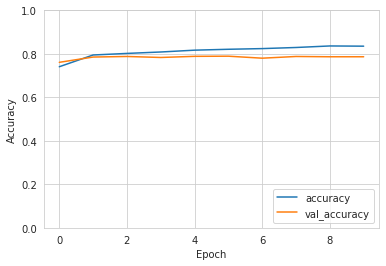

In [34]:
plt.plot(lstm_history.history['accuracy'], label='accuracy')
plt.plot(lstm_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')

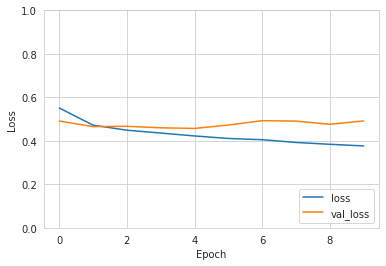

In [35]:
plt.plot(lstm_history.history['loss'], label = 'loss')
plt.plot(lstm_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')

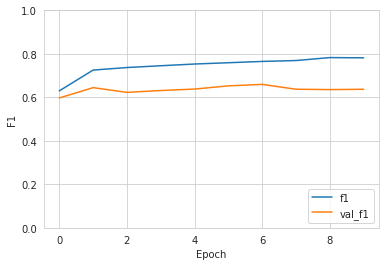

In [36]:
plt.plot(lstm_history.history['f1_m'], label = 'f1')
plt.plot(lstm_history.history['val_f1_m'], label = 'val_f1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')

In [37]:
# predict on testing set
y_pred_lstm = lstm_model.predict(test_array, verbose = 1)

102/102 [==============================] - 2s 8ms/step


In [38]:
# save to sample submission dataframe and save as csv
sample["target"] = [1 if i > 0.5 else 0 for i in y_pred_lstm]

In [39]:
sample.to_csv('Submission_lstm.csv', index = False)

## Glove+biLSTM

In [40]:
# tokenize both train and test
max_features = 10000
tok = text.Tokenizer(num_words = max_features, lower = True)
tok.fit_on_texts(list(X_train) + list(X_test))
X_train = tok.texts_to_sequences(X_train)
X_test = tok.texts_to_sequences(X_test)

In [41]:
# check word counts and sequence length distribution
print('Word counts: ', len(tok.word_counts))

X_train_lengths = [len(s) for s in X_train]
print('X train max length: ', np.max(X_train_lengths))

X_test_lengths = [len(s) for s in X_test]
print('X test max length: ', np.max(X_test_lengths))

Word counts:  17829
X train max length:  32
X test max length:  32


In [42]:
# set max length for padding
maxlen = 32
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen = maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen = maxlen)

In [43]:
# unzip embedding file
zipRef = zipfile.ZipFile('glove.840B.300d.zip','r')
zipRef.extractall()
zipRef.close()

In [44]:
# create embedding index using embedding file
embedding_index = dict()

with open(os.path.join('glove.840B.300d.txt'), encoding = 'utf8') as f:
    for line in f:
        tokens = line.rstrip().rsplit(' ')
        word = tokens[0]
        vector = np.asarray(tokens[1:], dtype = 'float32')
        embedding_index[word] = vector

In [45]:
# check embedding size
embedding_size = len(embedding_index['world'])

print('Total embedding vectors: ', len(embedding_index))
print('Size of embedding vector: ', embedding_size)

Total embedding vectors:  2196016
Size of embedding vector:  300


In [46]:
# prepare embedding matrix
embed_size = 300
word_index = tok.word_index

num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))

for word, idx in word_index.items():

    if idx >= max_features:
        continue
    embedding_vector = embedding_index.get(word)

    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [47]:
# model building
input = Input(shape = (maxlen, ))
x = Embedding(max_features, 
              embed_size, 
              weights = [embedding_matrix], 
              trainable = False)(input)
x = Dropout(0.3)(x)
x = Bidirectional(LSTM(units = 16,
                       activation = 'tanh',
                       return_sequences = True,
                       stateful = False,
                       recurrent_dropout = 0.4,
                       dropout = 0.4))(x)
x = Bidirectional(LSTM(units = 8,
                       activation ='tanh',
                       return_sequences = False,
                       stateful = False,
                       recurrent_dropout = 0.3,
                       dropout = 0.3))(x)
output = Dense(units = 1, 
               activation = "sigmoid")(x)

bilstm_model = Model(input, output)

# compile
bilstm_model.compile(loss = 'binary_crossentropy',
              optimizer = Adamax(lr = 0.01, decay = 0.0005, clipvalue = 10), 
              metrics = ['accuracy', f1_m])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adamax.py:95: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [48]:
bilstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 embedding (Embedding)       (None, 32, 300)           3000000   
                                                                 
 dropout_1 (Dropout)         (None, 32, 300)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 32, 32)           40576     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 16)               2624      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 17    

In [49]:
# train validation split
X_t, X_v, y_t, y_v = train_test_split(x_train, y_train, train_size = 0.8, random_state = 2)

In [50]:
# define parameters and file path
batch_size = 128
epochs = 10
filepath = "weights_base.best.hdf5"

checkpoint = ModelCheckpoint(filepath, 
                             monitor = 'val_f1_m', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 'max')

early = EarlyStopping(monitor = "val_f1_m", 
                      mode = "max", 
                      patience = 5)

callbacks_list = [checkpoint, early]

In [51]:
# model training
bilstm_history = bilstm_model.fit(X_t, y_t, 
                                  batch_size = batch_size, 
                                  epochs = epochs, 
                                  validation_data = (X_v, y_v), 
                                  callbacks = callbacks_list, 
                                  verbose = 1)

Epoch 1/10
48/48 [==============================] - ETA: 0s - loss: 0.5228 - accuracy: 0.7524 - f1_m: 0.6483
Epoch 1: val_f1_m improved from -inf to 0.72870, saving model to weights_base.best.hdf5
48/48 [==============================] - 28s 388ms/step - loss: 0.5228 - accuracy: 0.7524 - f1_m: 0.6483 - val_loss: 0.4424 - val_accuracy: 0.7991 - val_f1_m: 0.7287
Epoch 2/10
48/48 [==============================] - ETA: 0s - loss: 0.4538 - accuracy: 0.7957 - f1_m: 0.7379
Epoch 2: val_f1_m improved from 0.72870 to 0.77029, saving model to weights_base.best.hdf5
48/48 [==============================] - 17s 364ms/step - loss: 0.4538 - accuracy: 0.7957 - f1_m: 0.7379 - val_loss: 0.4252 - val_accuracy: 0.8004 - val_f1_m: 0.7703
Epoch 3/10
48/48 [==============================] - ETA: 0s - loss: 0.4325 - accuracy: 0.8062 - f1_m: 0.7546
Epoch 3: val_f1_m improved from 0.77029 to 0.77638, saving model to weights_base.best.hdf5
48/48 [==============================] - 17s 361ms/step - loss: 0.4325 

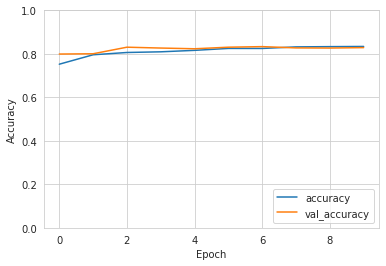

In [52]:
plt.plot(bilstm_history.history['accuracy'], label = 'accuracy')
plt.plot(bilstm_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')

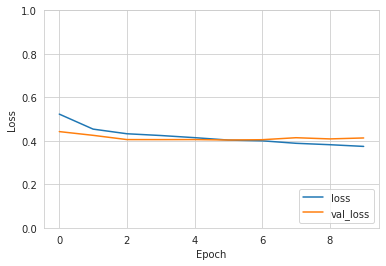

In [53]:
plt.plot(bilstm_history.history['loss'], label = 'loss')
plt.plot(bilstm_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')

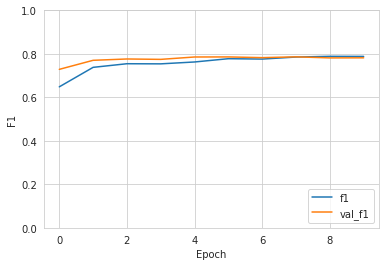

In [54]:
plt.plot(bilstm_history.history['f1_m'], label = 'f1')
plt.plot(bilstm_history.history['val_f1_m'], label = 'val_f1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')

In [55]:
# loading best model weights
bilstm_model.load_weights(filepath)

In [56]:
# predict on testing set
y_pred_bilstm = bilstm_model.predict(x_test, batch_size = 1024, verbose = 1)

4/4 [==============================] - 1s 41ms/step


In [57]:
# save to sample submission dataframe and save as csv
sample["target"] = [1 if i > 0.5 else 0 for i in y_pred_bilstm]

In [58]:
sample.to_csv('Submission_bilstm.csv', index=False)

## Bert+Bert

In [59]:
# prepare train and test set
tr, F, T = cleaner(train, stopWrds = False, Lemmatize = False, dropDigits = True, dropSinLet = False)
te, _, _ = cleaner(test, stopWrds = False, Lemmatize = False, dropDigits = True, dropSinLet = False, labeled = False)

In [60]:
# prepare validation set
np.random.seed(1)
r = np.random.uniform(low=0.0, high=1.0, size=train.shape[0])
y_tr_val = y_train[r > 0.2]
y_te_val = y_train[r <= 0.2]
tr_val, _, _ = cleaner(train.loc[r > 0.2], stopWrds = False, Lemmatize = False, dropDigits = True, dropSinLet = False)
te_val, _, _ = cleaner(train.loc[r <= 0.2], stopWrds = False, Lemmatize = False, dropDigits = True, dropSinLet = False, labeled = False)

In [61]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [62]:
# print max length
length_val = max([max([len(i) for i in tr_val]), max([len(i) for i in te_val])])
print(length_val)

150


In [63]:
# pretrained bert tokenizer
def prepareBERT(l, X, Y=None):
    inp_ids = []
    am = []

    for s in X:
        bert_inp = bert_tokenizer.encode_plus(
            s,
            add_special_tokens = True,
            max_length = l,
            padding ='max_length',
            return_attention_mask = True,
            truncation = True
        )
        inp_ids.append(bert_inp['input_ids'])
        am.append(bert_inp['attention_mask'])

    inp_ids = np.asarray(inp_ids)
    am = np.array(am)
    print(len(inp_ids))
    print(len(am))

    if Y is not None:
        print(len(Y))
    return inp_ids, am

In [64]:
# create inpud ids, and attention masks for train set
input_ids_te_val, attention_mask_te_val = prepareBERT(length_val, te_val, y_te_val)
input_ids_tr_val, attention_mask_tr_val = prepareBERT(length_val, tr_val, y_tr_val)

1520
1520
1520
6093
6093
6093


In [65]:
# create inpud ids, and attention masks for test set
input_ids_te, attention_mask_te = prepareBERT(length_val, te)

3263
3263


In [66]:
# model
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    hidden_dropout_prob = 0.15,
    attention_probs_dropout_prob = 0.15,
    hidden_act = "relu",
    num_labels = 2
)

bert_model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = Adam(lr = 5e-5, epsilon = 1e-08, clipvalue = 10),
    metrics = [SparseCategoricalAccuracy(), f1_m]
)
bert_model.trainable = True

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [67]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [68]:
# training
bert_history = bert_model.fit(
    [input_ids_tr_val, attention_mask_tr_val],
    y_tr_val,
    batch_size = 48,
    epochs = 2,
    validation_data = ([input_ids_te_val, attention_mask_te_val], y_te_val)
)

Epoch 1/2
127/127 [==============================] - 44s 197ms/step - loss: 0.4909 - sparse_categorical_accuracy: 0.7715 - f1_m: 0.4689 - val_loss: 0.3946 - val_sparse_categorical_accuracy: 0.8355 - val_f1_m: 0.5929
Epoch 2/2
127/127 [==============================] - 22s 171ms/step - loss: 0.3799 - sparse_categorical_accuracy: 0.8477 - f1_m: 0.5650 - val_loss: 0.4001 - val_sparse_categorical_accuracy: 0.8342 - val_f1_m: 0.5916


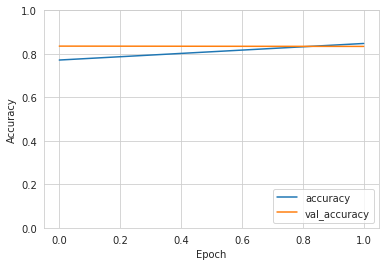

In [69]:
plt.plot(bert_history.history['sparse_categorical_accuracy'], label = 'accuracy')
plt.plot(bert_history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')

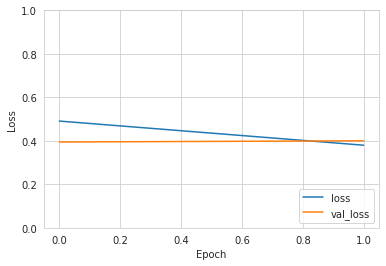

In [70]:
plt.plot(bert_history.history['loss'], label = 'loss')
plt.plot(bert_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')

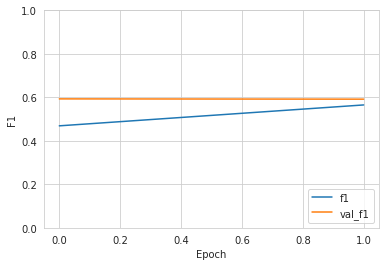

In [71]:
plt.plot(bert_history.history['f1_m'], label = 'f1')
plt.plot(bert_history.history['val_f1_m'], label = 'val_f1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')

In [72]:
# predict
y_pred_bert = bert_model.predict([input_ids_te, attention_mask_te], batch_size = 48)

68/68 [==============================] - 7s 59ms/step


In [73]:
y_pred_bert = [i[1] for i in softmax(y_pred_bert[0]).numpy().tolist()]

In [74]:
# save
sample["target"] = [1 if i > 0.5 else 0 for i in y_pred_bert]

In [75]:
sample.to_csv("Submission_BERT.csv", index=False)

## Roberta+Roberta

In [76]:
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [77]:
# print max length
length_val = max([max([len(i) for i in tr_val]), max([len(i) for i in te_val])])
print(length_val)

150


In [78]:
# pretrained roberta tokenizer
def prepareROBERTA(l, X, Y=None):
    inp_ids = []
    am = []

    for s in X:
        roberta_inp = roberta_tokenizer.encode_plus(
            s,
            add_special_tokens = True,
            max_length = l,
            padding ='max_length',
            return_attention_mask = True,
            truncation = True
        )
        inp_ids.append(roberta_inp['input_ids'])
        am.append(roberta_inp['attention_mask'])

    inp_ids = np.asarray(inp_ids)
    am = np.array(am)
    print(len(inp_ids));print(len(am))
    if Y is not None:
        print(len(Y))
    return inp_ids, am

In [79]:
# create inpud ids, and attention masks for train set
input_ids_te_val, attention_mask_te_val = prepareROBERTA(length_val, te_val, y_te_val)
input_ids_tr_val, attention_mask_tr_val = prepareROBERTA(length_val, tr_val, y_tr_val)

1520
1520
1520
6093
6093
6093


In [80]:
# create inpud ids, and attention masks for test set
input_ids_te, attention_mask_te = prepareROBERTA(length_val, te)

3263
3263


In [81]:
# model
roberta_model = TFRobertaForSequenceClassification.from_pretrained(
    'roberta-base', 
    hidden_dropout_prob = 0.15,
    attention_probs_dropout_prob = 0.15,
    hidden_act = "relu",
    num_labels = 2
)
roberta_model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = Adam(lr = 5e-5, epsilon = 1e-08,clipvalue = 10),
    metrics = [SparseCategoricalAccuracy(), f1_m]
)
roberta_model.trainable = True

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
roberta_model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592130    
 ficationHead)                                                   
                                                                 
Total params: 124,647,170
Trainable params: 124,647,170
Non-trainable params: 0
_________________________________________________________________


In [83]:
# training
roberta_history = roberta_model.fit(
    [input_ids_tr_val,attention_mask_tr_val],
    y_tr_val,
    batch_size = 48,
    epochs = 2,
    validation_data = ([input_ids_te_val, attention_mask_te_val], y_te_val)
)

Epoch 1/2
127/127 [==============================] - 42s 197ms/step - loss: 0.5447 - sparse_categorical_accuracy: 0.7189 - f1_m: 0.3556 - val_loss: 0.4312 - val_sparse_categorical_accuracy: 0.8118 - val_f1_m: 0.5810
Epoch 2/2
127/127 [==============================] - 22s 173ms/step - loss: 0.4169 - sparse_categorical_accuracy: 0.8236 - f1_m: 0.5263 - val_loss: 0.4205 - val_sparse_categorical_accuracy: 0.8191 - val_f1_m: 0.5293


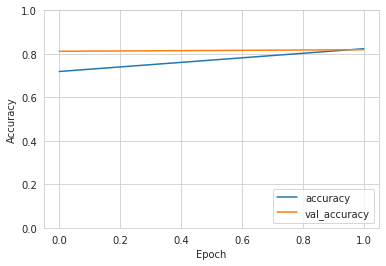

In [84]:
plt.plot(roberta_history.history['sparse_categorical_accuracy'], label = 'accuracy')
plt.plot(roberta_history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')

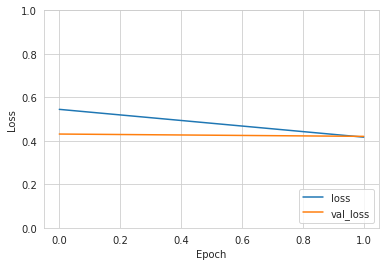

In [85]:
plt.plot(roberta_history.history['loss'], label = 'loss')
plt.plot(roberta_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')

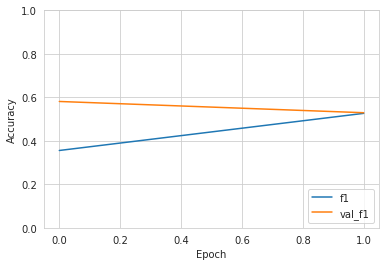

In [86]:
plt.plot(roberta_history.history['f1_m'], label = 'f1')
plt.plot(roberta_history.history['val_f1_m'], label = 'val_f1')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')

In [87]:
# predict
y_pred_roberta = roberta_model.predict([input_ids_te, attention_mask_te], batch_size = 48)

68/68 [==============================] - 7s 59ms/step


In [88]:
y_pred_roberta = [i[1] for i in softmax(y_pred_roberta[0]).numpy().tolist()]

In [89]:
# save
sample["target"] = [1 if i > 0.5 else 0 for i in y_pred_roberta]

In [90]:
sample.to_csv("Submission_ROBERTA.csv", index=False)

## Ensemble

In [91]:
s1 = pd.read_csv("/content/Submission_lstm.csv")
s2 = pd.read_csv("/content/Submission_bilstm.csv")
s3 = pd.read_csv("/content/Submission_BERT.csv")
s4 = pd.read_csv("/content/Submission_ROBERTA.csv")

In [92]:
# majority voting
Voting = np.where(s1.target + s2.target + s3.target + s4.target >= 3, 1, 0)
sample["target"] = Voting
sample.to_csv("Submission_Voting_v4.csv", index=False)

In [93]:
# only bilstm and bert
Voting = np.where(s2.target + s3.target >= 1, 1, 0)
sample["target"] = Voting
sample.to_csv("Submission_Voting_v2.csv", index=False)